In [1]:
import torch
import numpy as np
import random
import os
from torch import nn
from tqdm import tqdm

from einops import rearrange

import torch.optim as optim
from tensorboardX import SummaryWriter

from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from matplotlib import pyplot as plt

from torch.nn import functional as F

from torch.utils import data
from torchvision.utils import save_image

from image_quality_assessment import PSNR, SSIM
from basicsr.archs.arch_util import trunc_normal_, to_2tuple

/home/ashutosh/anaconda3/envs/swinUIR/lib/python3.9/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

print("Using device: {}".format(device))

Using device: cuda:0


In [3]:
# Fixed random number seed
SEED = 99

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
def make_directory(dir_path: str) -> None:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [5]:
class Mlp(nn.Module):

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [6]:
class ChannelAttention(nn.Module):
    """
    3.3 Channel Attention (CA)
    Previous CNN-based SR methods treat LR channel-wise features equally, which
    is not flexible for the real cases. In order to make the network focus on more
    informative features, we exploit the interdependencies among feature channels,
    resulting in a channel attention (CA) mechanism (see Figure 3).
    How to generate different attention for each channel-wise feature is a key
    step. Here we mainly have two concerns: First, information in the LR space
    has abundant low-frequency and valuable high-frequency components. The low-
    frequency parts seem to be more complanate. The high-frequency components
    would usually be regions, being full of edges, texture, and other details. On the
    other hand, each filter in Conv layer operates with a local receptive field. Conse-
    quently, the output after convolution is unable to exploit contextual information
    outside of the local region.
    Based on these analyses, we take the channel-wise global spatial information
    into a channel descriptor by using global average pooling. As shown in Figure 3,
    let X = [x1 , · · · , xc , · · · , xC ] be an input, which has C feature maps with size
    of H × W . The channel-wise statistic z ∈ RC can be obtained by shrinking X
    through spatial dimensions H × W . Then the c-th element of z is determined by
    zc = HGP (xc ) = W H X X 1x c (i, j) , H × W i=1 j=1                          (10)
    where xc (i, j) is the value at position (i, j) of c-th feature xc . HGP (·) denotes the
    global pooling function. Such channel statistic can be viewed as a collection of
    the local descriptors, whose statistics contribute to express the whole image [23].
    Except for global average pooling, more sophisticated aggregation techniques
    could also be introduced here.
    To fully capture channel-wise dependencies from the aggregated informa-
    tion by global average pooling, we introduce a gating mechanism. As discussed
    in [23], the gating mechanism should meet two criteria: First, it must be able
    to learn nonlinear interactions between channels. Second, as multiple channel-
    wise features can be emphasized opposed to one-hot activation, it must learn
    a non-mututually-exclusive relationship. Here, we opt to exploit simple gating
    mechanism with sigmoid function
    s = f (WU δ (WD z)) ,                                                            (11)
    where f (·) and δ (·) denote the sigmoid gating and ReLU [34] function, respec-
    tively. WD is the weight set of a Conv layer, which acts as channel-downscaling
    with reduction ratio r. After being activated by ReLU, the low-dimension signal
    is then increased with ratio r by a channel-upscaling layer, whose weight set is
    WU . Then we obtain the final channel statistics s, which is used to rescale the
    input xc x bc = sc · xc ,                                                        (12)
    where sc and xc are the scaling factor and feature map in the c-th channel. With
    channel attention, the residual component in the RCAB is adaptively rescaled.
    """
    def __init__(self, num_features, squeeze_factor = 16):
        super(ChannelAttention, self).__init__()

        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(num_features, num_features // squeeze_factor, 1, padding = 0),
            nn.ReLU(inplace = True),
            nn.Conv2d(num_features // squeeze_factor, num_features, 1, padding = 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.attention(x)
        return x * y

In [7]:
class CAB(nn.Module):
    """
    As discussed above, residual groups and long skip connection allow the main
    parts of network to focus on more informative components of the LR features.
    Channel attention extracts the channel statistic among channels to further en-
    hance the discriminative ability of the network.
    At the same time, inspired by the success of residual blocks (RB) in [10], we
    integrate CA into RB and propose residual channel attention block (RCAB) (
    see Figure 4). For the b-th RB in g-th RG, we have 
    Fg,b = Fg,b−1 + Rg,b (Xg,b ) · Xg,b ,                                     (13)
    where Rg,b denotes the function of channel attention. Fg,b and Fg,b−1 are the
    input and output of RCAB, which learns the residual Xg,b from the input.
    """
    def __init__(self, num_feat, compress_ratio = 3, squeeze_factor = 30):
        super(CAB, self).__init__()

        self.cab = nn.Sequential(
            nn.Conv2d(num_feat, num_feat // compress_ratio, 3, 1, 1),
            nn.GELU(),
            nn.Conv2d(num_feat // compress_ratio, num_feat, 3, 1, 1),
            ChannelAttention(num_feat, squeeze_factor)
        )

    def forward(self, x):
        return self.cab(x)

In [8]:
# model = CAB(6, 3, 2)

# ex = torch.ones((1, 6, 4, 4))

# print(ex, ex.shape)

# out = model(ex)
# # print(out, out.shape)

In [9]:
def window_partition(x, window_size):
    """
    Args:
        x: (b, h, w, c)
        window_size (int): window size

    Returns:
        windows: (num_windows * b, window_size, window_size, c)
    """

    b, h, w, c = x.shape
    x = x.view(b, h // window_size, window_size, w // window_size, window_size, c)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, c)
    return windows

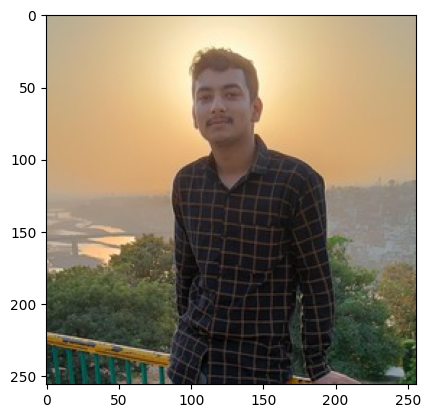

In [10]:


img = Image.open("./profile_pic.png")

to_tensor = transforms.ToTensor()

img = to_tensor(img)
plt.imshow(img.permute(1, 2, 0))

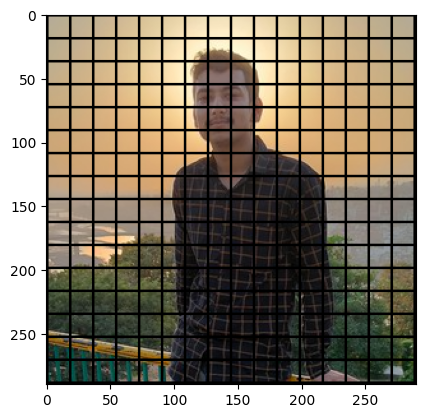

In [11]:
img_reshaped = img.unsqueeze(0).permute(0, 2, 3, 1)
windows = window_partition(img_reshaped, 16)

plt.imshow(make_grid(windows.permute(0, 3, 1, 2), nrow = 16).permute(1, 2, 0))

In [12]:
def window_reverse(windows, window_size, h, w):

    b = int(windows.shape[0] / (h * w / window_size / window_size))
    x = windows.view(b, h // window_size, w // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
    return x

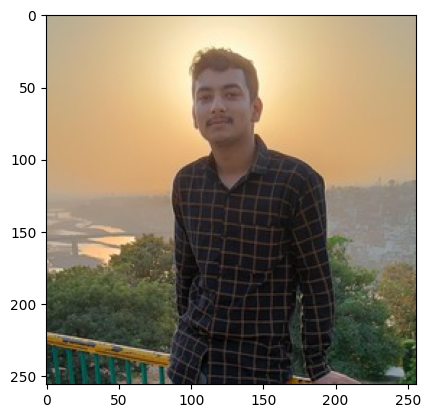

In [13]:
reverse_img = window_reverse(windows, 16, 256, 256)

plt.imshow(reverse_img.squeeze(0))

In [14]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    From: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0], ) + (1, ) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).

    From: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


In [15]:

class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional): If true, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override deafult qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias = True,
        qk_scale = None,
        attn_drop = 0.,
        proj_drop = 0.
    ):
        super(WindowAttention, self).__init__()

        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))

        self.qkv = nn.Linear(dim, dim * 3, bias = qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std = .02)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, x, rpi, mask = None):
        """
        Args:
            x: input features with shape of (num_windows*b, n, c)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        b_, n, c = x.shape
        qkv = self.qkv(x).reshape(b_, n, 3, self.num_heads, c // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[rpi.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nw = mask.shape[0]
            attn = attn.view(b_ // nw, nw, self.num_heads, n, n) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, n, n)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(b_, n, c)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [16]:
class HAB(nn.Module):

    r""" Hybrid Attention Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self,
                 dim,
                 input_resolution,
                 num_heads,
                 window_size = 7,
                 shift_size = 0,
                 compress_ratio = 3,
                 squeeze_factor = 30,
                 conv_scale = 0.01,
                 mlp_ratio = 4.,
                 qkv_bias = True,
                 qk_scale = None,
                 drop = 0.,
                 attn_drop = 0.,
                 drop_path = 0.,
                 act_layer = nn.GELU,
                 norm_layer = nn.LayerNorm):
        super(HAB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows.
            self.shift_size = 0
            self.window_size = min(self.input_resolution)

        assert 0 <= self.shift_size < self.window_size, 'shift_size must in 0-window_size'

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size = to_2tuple(self.window_size),
            num_heads = num_heads,
            qkv_bias = qkv_bias,
            qk_scale = qk_scale,
            attn_drop = attn_drop,
            proj_drop = drop
        )

        self.conv_scale = conv_scale
        self.conv_block = CAB(num_feat = dim, compress_ratio = compress_ratio, squeeze_factor = squeeze_factor)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)

        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features = dim, hidden_features = mlp_hidden_dim, act_layer = act_layer, drop = drop)


    def forward(self, x, x_size, rpi_sa, attn_mask):
        h, w = x_size
        b, _, c = x.shape
        # assert seq_len == h * w, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(b, h, w, c)


        # Conv_X
        conv_x = self.conv_block(x.permute(0, 3, 1, 2))
        conv_x = conv_x.permute(0, 2, 3, 1).contiguous().view(b, h * w, c)

        # Cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts = (-self.shift_size, -self.shift_size), dims = (1, 2))
            attn_mask = attn_mask
        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size) # nw*b, window_size, window_size, c
        x_windows = x_windows.view(-1, self.window_size * self.window_size, c) # nw*b, window_size * window_size, c

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size)
        attn_windows = self.attn(x_windows, rpi = rpi_sa, mask = attn_mask)

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, c)
        shifted_x = window_reverse(attn_windows, self.window_size, h, w) # b h' w' c

        # reverse cyclic shift
        if self.shift_size > 0:
            attn_x = torch.roll(shifted_x, shifts = (self.shift_size, self.shift_size), dims = (1, 2))
        else:
            attn_x = shifted_x

        attn_x = attn_x.view(b, h * w, c)

        # FFN
        x = shortcut + self.drop_path(attn_x) + conv_x * self.conv_scale
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x
        

In [17]:
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: b, h*w, c
        """
        h, w = self.input_resolution
        b, seq_len, c = x.shape
        assert seq_len == h * w, 'input feature has wrong size'
        assert h % 2 == 0 and w % 2 == 0, f'x size ({h}*{w}) are not even.'

        x = x.view(b, h, w, c)

        x0 = x[:, 0::2, 0::2, :]  # b h/2 w/2 c
        x1 = x[:, 1::2, 0::2, :]  # b h/2 w/2 c
        x2 = x[:, 0::2, 1::2, :]  # b h/2 w/2 c
        x3 = x[:, 1::2, 1::2, :]  # b h/2 w/2 c
        x = torch.cat([x0, x1, x2, x3], -1)  # b h/2 w/2 4*c
        x = x.view(b, -1, 4 * c)  # b h/2*w/2 4*c

        x = self.norm(x)
        x = self.reduction(x)

        return x


class OCAB(nn.Module):
    # overlapping cross-attention block

    def __init__(self, dim,
                input_resolution,
                window_size,
                overlap_ratio,
                num_heads,
                qkv_bias=True,
                qk_scale=None,
                mlp_ratio=2,
                norm_layer=nn.LayerNorm
                ):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5
        self.overlap_win_size = int(window_size * overlap_ratio) + window_size

        self.norm1 = norm_layer(dim)
        self.qkv = nn.Linear(dim, dim * 3,  bias=qkv_bias)
        self.unfold = nn.Unfold(kernel_size=(self.overlap_win_size, self.overlap_win_size), stride=window_size, padding=(self.overlap_win_size-window_size)//2)

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((window_size + self.overlap_win_size - 1) * (window_size + self.overlap_win_size - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

        self.proj = nn.Linear(dim,dim)

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=nn.GELU)

    def forward(self, x, x_size, rpi):
        h, w = x_size
        b, _, c = x.shape

        shortcut = x
        x = self.norm1(x)
        x = x.view(b, h, w, c)

        qkv = self.qkv(x).reshape(b, h, w, 3, c).permute(3, 0, 4, 1, 2) # 3, b, c, h, w
        q = qkv[0].permute(0, 2, 3, 1) # b, h, w, c
        kv = torch.cat((qkv[1], qkv[2]), dim=1) # b, 2*c, h, w

        # partition windows
        q_windows = window_partition(q, self.window_size)  # nw*b, window_size, window_size, c
        q_windows = q_windows.view(-1, self.window_size * self.window_size, c)  # nw*b, window_size*window_size, c

        kv_windows = self.unfold(kv) # b, c*w*w, nw
        kv_windows = rearrange(kv_windows, 'b (nc ch owh oww) nw -> nc (b nw) (owh oww) ch', nc=2, ch=c, owh=self.overlap_win_size, oww=self.overlap_win_size).contiguous() # 2, nw*b, ow*ow, c
        k_windows, v_windows = kv_windows[0], kv_windows[1] # nw*b, ow*ow, c

        b_, nq, _ = q_windows.shape
        _, n, _ = k_windows.shape
        d = self.dim // self.num_heads
        q = q_windows.reshape(b_, nq, self.num_heads, d).permute(0, 2, 1, 3) # nw*b, nH, nq, d
        k = k_windows.reshape(b_, n, self.num_heads, d).permute(0, 2, 1, 3) # nw*b, nH, n, d
        v = v_windows.reshape(b_, n, self.num_heads, d).permute(0, 2, 1, 3) # nw*b, nH, n, d

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[rpi.view(-1)].view(
            self.window_size * self.window_size, self.overlap_win_size * self.overlap_win_size, -1)  # ws*ws, wse*wse, nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, ws*ws, wse*wse
        attn = attn + relative_position_bias.unsqueeze(0)

        attn = self.softmax(attn)
        attn_windows = (attn @ v).transpose(1, 2).reshape(b_, nq, self.dim)

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, self.dim)
        x = window_reverse(attn_windows, self.window_size, h, w)  # b h w c
        x = x.view(b, h * w, self.dim)

        x = self.proj(x) + shortcut

        x = x + self.mlp(self.norm2(x))
        return x


In [18]:
class AttenBlocks(nn.Module):
    """ A series of attention blocks for one RHAG.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention drop rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """
    
    def __init__(self,
                 dim,
                 input_resolution,
                 depth,
                 num_heads,
                 window_size,
                 compress_ratio,
                 squeeze_factor,
                 conv_scale,
                 overlap_ratio,
                 mlp_ratio = 4.,
                 qkv_bias = True,
                 qk_scale = None,
                 drop = 0.,
                 attn_drop = 0.,
                 drop_path = 0.,
                 norm_layer = nn.LayerNorm,
                 downsample = None,
                 use_checkpoint = False):

        super(AttenBlocks, self).__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            HAB(
                dim = dim,
                input_resolution = input_resolution,
                num_heads = num_heads,
                window_size = window_size,
                shift_size = 0 if (i % 2 == 0) else window_size // 2,
                compress_ratio = compress_ratio,
                squeeze_factor = squeeze_factor,
                conv_scale = conv_scale,
                mlp_ratio = mlp_ratio,
                qkv_bias = qkv_bias,
                qk_scale = qk_scale,
                drop = drop,
                attn_drop = attn_drop,
                drop_path = drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer = norm_layer) for i in range(depth)])


        # OCAB
        self.overlap_attn = OCAB(
                                dim = dim,
                                input_resolution = input_resolution,
                                window_size = window_size,
                                overlap_ratio = overlap_ratio,
                                num_heads = num_heads,
                                qkv_bias = qkv_bias,
                                qk_scale = qk_scale,
                                mlp_ratio = mlp_ratio,
                                norm_layer = norm_layer)

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim = dim, norm_layer = norm_layer)
        else:
            self.downsample = None

    
    def forward(self, x, x_size, params):
        for blk in self.blocks:
            x = blk(x, x_size, params['rpi_sa'], params['attn_mask'])

        x = self.overlap_attn(x, x_size, params['rpi_oca'])

        if self.downsample is not None:
            x = self.downsample(x)

        return x

In [19]:
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # b Ph*Pw c
        if self.norm is not None:
            x = self.norm(x)
        return x


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        x = x.transpose(1, 2).contiguous().view(x.shape[0], self.embed_dim, x_size[0], x_size[1])  # b Ph*Pw c
        return x

In [20]:
class RHAG(nn.Module):
    """Residual Hybrid Attention Group (RHAG).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Defautl: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self,
                 dim,
                 input_resolution,
                 depth,
                 num_heads,
                 window_size,
                 compress_ratio,
                 squeeze_factor,
                 conv_scale,
                 overlap_ratio,
                 mlp_ratio = 4.,
                 qkv_bias = True,
                 qk_scale = None,
                 drop = 0.,
                 attn_drop = 0.,
                 drop_path = 0.,
                 norm_layer = nn.LayerNorm,
                 downsample = None,
                 use_checkpoint = False,
                 img_size = 224,
                 patch_size = 4,
                 resi_connection = '1conv'):
        super(RHAG, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = AttenBlocks(
            dim=dim,
            input_resolution=input_resolution,
            depth=depth,
            num_heads=num_heads,
            window_size=window_size,
            compress_ratio=compress_ratio,
            squeeze_factor=squeeze_factor,
            conv_scale=conv_scale,
            overlap_ratio=overlap_ratio,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            drop=drop,
            attn_drop=attn_drop,
            drop_path=drop_path,
            norm_layer=norm_layer,
            downsample=downsample,
            use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == 'identity':
            self.conv = nn.Identity()

        self.patch_embed = PatchEmbed(
            img_size = img_size, patch_size = patch_size, in_chans = 0, embed_dim = dim, norm_layer = None)

        self.patch_unembed = PatchUnEmbed(
            img_size = img_size, patch_size = patch_size, in_chans = 0, embed_dim = dim, norm_layer = None)


    def forward(self, x, x_size, params):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size, params), x_size))) + x

In [21]:
class Down(nn.Module):
    def __init__(self, in_channels, chan_factor, bias=False):
        super(Down, self).__init__()

        self.bot = nn.Sequential(
            nn.AvgPool2d(2, ceil_mode=True, count_include_pad=False),
            nn.Conv2d(in_channels, int(in_channels * chan_factor), 1, stride=1, padding=0, bias=bias)
        )

    def forward(self, x):
        return self.bot(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, scale_factor, chan_factor=2, kernel_size=3):
        super(DownSample, self).__init__()
        self.scale_factor = int(np.log2(scale_factor))

        modules_body = []
        for i in range(self.scale_factor):
            modules_body.append(Down(in_channels, chan_factor))
            in_channels = int(in_channels * chan_factor)

        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        x = self.body(x)
        return x

In [22]:
class Up(nn.Module):
    def __init__(self, in_channels, chan_factor, bias=False):
        super(Up, self).__init__()

        self.bot = nn.Sequential(
            nn.Conv2d(in_channels, int(in_channels // chan_factor), 1, stride=1, padding=0, bias=bias),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=bias)
        )

    def forward(self, x):
        return self.bot(x)


class UpSample(nn.Module):
    def __init__(self, in_channels, scale_factor, chan_factor=2, kernel_size=3):
        super(UpSample, self).__init__()
        self.scale_factor = int(np.log2(scale_factor))

        modules_body = []
        for i in range(self.scale_factor):
            modules_body.append(Up(in_channels, chan_factor))
            in_channels = int(in_channels // chan_factor)

        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        x = self.body(x)
        return x


In [23]:
class CSAF(nn.Module):
    def __init__(self, in_chnls, ratio=4):
        super(CSAF, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1, 1))
        self.compress1 = nn.Conv2d(in_chnls, in_chnls // ratio, 1, 1, 0)
        self.compress2 = nn.Conv2d(in_chnls // ratio, in_chnls // ratio, 1, 1, 0)
        self.excitation = nn.Conv2d(in_chnls // ratio, in_chnls, 1, 1, 0)

    def forward(self, x0, x2, x4):
        out0 = self.squeeze(x0)
        out2 = self.squeeze(x2)
        out4 = self.squeeze(x4)
        out = torch.cat([out0, out2, out4], dim=1)
        out = self.compress1(out)
        out = F.relu(out)
        out = self.compress2(out)
        out = F.relu(out)
        out = self.excitation(out)
        out = F.sigmoid(out)
        w0, w2, w4 = torch.chunk(out, 3, dim=1)
        x = x0 * w0 + x2 * w2 + x4 * w4

        return x

In [24]:
# Attention Feature Fusion (AFF)
class AFF(nn.Module):
    def __init__(self, channels, activation, r=4):
        super(AFF, self).__init__()
        inter_channels = int(channels // r)

        self.local_att = nn.Sequential(
            nn.Conv2d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            activation,
            nn.Conv2d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
        )

        self.global_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, inter_channels, kernel_size=1, stride=1, padding=0),
            activation,
            nn.Conv2d(inter_channels, channels, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x, residual):
        xa = x + residual
        xl = self.local_att(xa)
        xg = self.global_att(xa)
        xlg = xl + xg
        wei = torch.sigmoid(xlg)

        xo = 2 * x * wei + 2 * residual * (1 - wei)
        return xo

In [25]:
class MyModel(nn.Module):
    r""" Hybrid Attention Transformer
    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction module. 'pixelshuffle'/'pixelshuffleddirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self,
                 img_size = 64,
                 patch_size = 1,
                 in_chans = 3,
                 embed_dim = 96,
                 depths = (6, 6, 6, 6),
                 num_heads = (6, 6, 6, 6),
                 window_size = 7,
                 compress_ratio = 3,
                 squeeze_factor = 30,
                 conv_scale = 0.01,
                 overlap_ratio = 0.5,
                 mlp_ratio = 4.,
                 qkv_bias = True,
                 qk_scale = None,
                 drop_rate = 0.,
                 attn_drop_rate = 0.,
                 drop_path_rate = 0.1,
                 norm_layer = nn.LayerNorm,
                 ape = False,
                 patch_norm = True,
                 use_checkpoint = False,
                 upscale = 1,
                 img_range = 1.,
                 upsampler = '',
                 resi_connection = '1conv',
                 chan_factor = 2,
                 **kwargs):
        super(MyModel, self).__init__()

        self.window_size = window_size
        self.shift_size = window_size // 2
        self.overlap_ratio = overlap_ratio

        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range

        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)


        self.upscale = upscale
        self.upsampler = upsampler

        # relative position index.
        relative_position_index_SA = self.calculate_rpi_sa()
        relative_position_index_OCA = self.calculate_rpi_oca()
        self.register_buffer('relative_position_index_SA', relative_position_index_SA)
        self.register_buffer('relative_position_index_OCA', relative_position_index_OCA)

        # Downsample layers
        self.down_2 = DownSample(int((chan_factor ** 0) * embed_dim), 2, chan_factor)
        self.down_4 = nn.Sequential(
            DownSample(int((chan_factor ** 0) * embed_dim), 2, chan_factor),
            DownSample(int((chan_factor ** 1) * embed_dim), 2, chan_factor)
        )

        # Upsample layers
        self.up_2 = UpSample(int((chan_factor ** 1) * embed_dim), 2, chan_factor)
        self.up_4 = nn.Sequential(
            UpSample(int((chan_factor ** 2) * embed_dim), 2, chan_factor),
            UpSample(int((chan_factor ** 1) * embed_dim), 2, chan_factor),
        )
        

        # 1. Shallow feature extraction.
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        # 2. Deep feature extraction.
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio


        # split image into non-overlapping patches (1 X)
        self.patch_embed_1 = PatchEmbed(
            img_size = img_size,
            patch_size = patch_size,
            in_chans = embed_dim,
            embed_dim = embed_dim,
            norm_layer = norm_layer if self.patch_norm else None)

        num_patches_1 = self.patch_embed_1.num_patches
        patches_resolution_1 = self.patch_embed_1.patches_resolution
        self.patches_resolution_1 = patches_resolution_1

        # merge non-overlapping patches into image
        self.patch_unembed_1 = PatchUnEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=embed_dim,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        
        # split image into non-overlapping patches (2X)
        self.patch_embed_2 = PatchEmbed(
            img_size = img_size // 2,
            patch_size = patch_size,
            in_chans = embed_dim * 2,
            embed_dim = embed_dim * 2,
            norm_layer = norm_layer if self.patch_norm else None)

        num_patches_2 = self.patch_embed_2.num_patches
        patches_resolution_2 = self.patch_embed_2.patches_resolution
        self.patches_resolution_2 = patches_resolution_2

        # merge non-overlapping patches into image
        self.patch_unembed_2 = PatchUnEmbed(
            img_size=img_size // 2,
            patch_size=patch_size,
            in_chans=embed_dim * 2,
            embed_dim=embed_dim * 2,
            norm_layer=norm_layer if self.patch_norm else None)
        
        
        # split image into non-overlapping patches (2X)
        self.patch_embed_4 = PatchEmbed(
            img_size = img_size,
            patch_size = patch_size,
            in_chans = embed_dim * 4,
            embed_dim = embed_dim * 4,
            norm_layer = norm_layer if self.patch_norm else None)

        num_patches_4 = self.patch_embed_4.num_patches
        patches_resolution_4 = self.patch_embed_4.patches_resolution
        self.patches_resolution_4 = patches_resolution_4

        # merge non-overlapping patches into image
        self.patch_unembed_4 = PatchUnEmbed(
            img_size=img_size // 4,
            patch_size=patch_size,
            in_chans=embed_dim * 4,
            embed_dim=embed_dim * 4,
            norm_layer=norm_layer if self.patch_norm else None)
        
        
        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed_1 = nn.Parameter(torch.zeros(1, num_patches_1, embed_dim))
            trunc_normal_(self.absolute_pos_embed_1, std = .02)

            self.absolute_pos_embed_2 = nn.Parameter(torch.zeros(1, num_patches_2, embed_dim))
            trunc_normal_(self.absolute_pos_embed_2, std = .02)
    
            self.absolute_pos_embed_4 = nn.Parameter(torch.zeros(1, num_patches_4, embed_dim))
            trunc_normal_(self.absolute_pos_embed_4, std = .02)

        self.pos_drop = nn.Dropout(p = drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] # stochastic depth decay rule

        # build Residual Hybrid Attention Groups (RHAG)
        self.layers_1 = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RHAG(
                dim = embed_dim,
                input_resolution = (patches_resolution_1[0], patches_resolution_1[1]),
                depth = depths[i_layer],
                num_heads = num_heads[i_layer],
                window_size = window_size,
                compress_ratio = compress_ratio,
                squeeze_factor = squeeze_factor,
                conv_scale = conv_scale,
                overlap_ratio = overlap_ratio,
                mlp_ratio = self.mlp_ratio,
                qkv_bias = qkv_bias,
                qk_scale = qk_scale,
                drop = drop_rate,
                attn_drop = attn_drop_rate,
                drop_path = dpr[sum(depths[:i_layer]): sum(depths[:i_layer + 1])], # no impact on SR results.
                norm_layer = norm_layer,
                downsample = None,
                use_checkpoint = use_checkpoint,
                img_size = img_size,
                patch_size = patch_size,
                resi_connection = resi_connection
            )
            self.layers_1.append(layer)

        self.layers_2 = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RHAG(
                dim = embed_dim * 2,
                input_resolution = (patches_resolution_2[0], patches_resolution_2[1]),
                depth = depths[i_layer],
                num_heads = num_heads[i_layer],
                window_size = window_size,
                compress_ratio = compress_ratio,
                squeeze_factor = squeeze_factor,
                conv_scale = conv_scale,
                overlap_ratio = overlap_ratio,
                mlp_ratio = self.mlp_ratio,
                qkv_bias = qkv_bias,
                qk_scale = qk_scale,
                drop = drop_rate,
                attn_drop = attn_drop_rate,
                drop_path = dpr[sum(depths[:i_layer]): sum(depths[:i_layer + 1])], # no impact on SR results.
                norm_layer = norm_layer,
                downsample = None,
                use_checkpoint = use_checkpoint,
                img_size = img_size // 2,
                patch_size = patch_size,
                resi_connection = resi_connection
            )
            self.layers_2.append(layer)

        self.layers_4 = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RHAG(
                dim = embed_dim * 4,
                input_resolution = (patches_resolution_4[0], patches_resolution_4[1]),
                depth = depths[i_layer],
                num_heads = num_heads[i_layer],
                window_size = window_size,
                compress_ratio = compress_ratio,
                squeeze_factor = squeeze_factor,
                conv_scale = conv_scale,
                overlap_ratio = overlap_ratio,
                mlp_ratio = self.mlp_ratio,
                qkv_bias = qkv_bias,
                qk_scale = qk_scale,
                drop = drop_rate,
                attn_drop = attn_drop_rate,
                drop_path = dpr[sum(depths[:i_layer]): sum(depths[:i_layer + 1])], # no impact on SR results.
                norm_layer = norm_layer,
                downsample = None,
                use_checkpoint = use_checkpoint,
                img_size = img_size // 4,
                patch_size = patch_size,
                resi_connection = resi_connection
            )
            self.layers_4.append(layer)

        self.norm_1 = norm_layer(self.num_features)
        self.norm_2 = norm_layer(self.num_features * 2)
        self.norm_4 = norm_layer(self.num_features * 4)

        # build the last conv layer in deep feature extraction.
        if resi_connection == '1conv':
            self.conv_after_body_1 = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
            self.conv_after_body_2 = nn.Conv2d(embed_dim * 2, embed_dim * 2, 3, 1, 1)
            self.conv_after_body_4 = nn.Conv2d(embed_dim * 4, embed_dim * 4, 3, 1, 1)
        elif resi_connection == 'identity':
            self.conv_after_body_1 = nn.Identity()
            self.conv_after_body_2 = nn.Identity()
            self.conv_after_body_4 = nn.Identity()

        # Reconstruction.
        self.conv_before_upsample = nn.Sequential(
            nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
            nn.LeakyReLU(inplace = True)
        )

        self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)

        # Channel attention fusion.
        self.fusion = CSAF(in_chnls = 3 * embed_dim)
        
        self.aff_top = AFF(int(embed_dim * chan_factor ** 0), nn.LeakyReLU(0.1, True))
        self.aff_mid = AFF(int(embed_dim * chan_factor ** 1), nn.LeakyReLU(0.1, True))

        self.up21_1 = UpSample(int((chan_factor ** 1) * embed_dim), 2, chan_factor)
        self.up32_1 = UpSample(int((chan_factor ** 2) * embed_dim), 2, chan_factor)

        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std = .02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    def calculate_rpi_sa(self):
        # calculate relative position index for SA
        coords_h = torch.arange(self.window_size)
        coords_w = torch.arange(self.window_size)
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size - 1
        relative_coords[:, :, 0] *= 2 * self.window_size - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        return relative_position_index


    def calculate_rpi_oca(self):
        # calculate relative position index for OCA
        window_size_ori = self.window_size
        window_size_ext = self.window_size + int(self.overlap_ratio * self.window_size)

        coords_h = torch.arange(window_size_ori)
        coords_w = torch.arange(window_size_ori)
        coords_ori = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, ws, ws
        coords_ori_flatten = torch.flatten(coords_ori, 1)  # 2, ws*ws

        coords_h = torch.arange(window_size_ext)
        coords_w = torch.arange(window_size_ext)
        coords_ext = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, wse, wse
        coords_ext_flatten = torch.flatten(coords_ext, 1)  # 2, wse*wse

        relative_coords = coords_ext_flatten[:, None, :] - coords_ori_flatten[:, :, None]   # 2, ws*ws, wse*wse

        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # ws*ws, wse*wse, 2
        relative_coords[:, :, 0] += window_size_ori - window_size_ext + 1  # shift to start from 0
        relative_coords[:, :, 1] += window_size_ori - window_size_ext + 1

        relative_coords[:, :, 0] *= window_size_ori + window_size_ext - 1
        relative_position_index = relative_coords.sum(-1)
        return relative_position_index


    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        h, w = x_size
        img_mask = torch.zeros((1, h, w, 1)) # 1 h w 1
        h_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))

        w_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))

        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)                        # nw, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask


    # def no_weight_decay(self):
    #     return {'absolute_pos_embed'}


    # def no_weight_decay_keywords(self):
    #     return {'relative_position_bias_table'}

    def forward(self, x):
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range
        
        x = self.conv_first(x)
        x_1 = x
        x_2 = self.down_2(x)
        x_4 = self.down_4(x)
        # print('x_1 shape', x_1.shape)
        # print('x_2 shape', x_2.shape)
        # print('x_4 shape', x_4.shape)

    
        x_1_size = (x_1.shape[2], x_1.shape[3])

        # Calculate attention mask and relative position index in advance to speed up inference.
        # The original code is very time-consuming for large window size.
        attn_mask_1 = self.calculate_mask(x_1_size).to(x_1.device)
        params_1 = {'attn_mask': attn_mask_1, 'rpi_sa': self.relative_position_index_SA, 'rpi_oca': self.relative_position_index_OCA}



        x_2_size = (x_2.shape[2], x_2.shape[3])

        # Calculate attention mask and relative position index in advance to speed up inference.
        # The original code is very time-consuming for large window size.
        attn_mask_2 = self.calculate_mask(x_2_size).to(x_2.device)
        params_2 = {'attn_mask': attn_mask_2, 'rpi_sa': self.relative_position_index_SA, 'rpi_oca': self.relative_position_index_OCA}



        x_4_size = (x_4.shape[2], x_4.shape[3])

        # Calculate attention mask and relative position index in advance to speed up inference.
        # The original code is very time-consuming for large window size.
        attn_mask_4 = self.calculate_mask(x_4_size).to(x_4.device)
        params_4 = {'attn_mask': attn_mask_4, 'rpi_sa': self.relative_position_index_SA, 'rpi_oca': self.relative_position_index_OCA}



        for i in range(self.num_layers):
            x_1 = self.patch_embed_1(x_1)
            if self.ape:
                x_1 = x_1 + self.absolute_pos_embed_1
    
            x_1 = self.pos_drop(x_1)

            x_2 = self.patch_embed_2(x_2)
            if self.ape:
                x_2 = x_2 + self.absolute_pos_embed_2

            x_2 = self.pos_drop(x_2)

            x_4 = self.patch_embed_4(x_4)
            if self.ape:
                x_4 = x_4 + self.absolute_pos_embed_4
    
            x_4 = self.pos_drop(x_4)

            x_1 = self.layers_1[i](x_1, x_1_size, params_1)
            x_2 = self.layers_2[i](x_2, x_2_size, params_2)
            x_4 = self.layers_4[i](x_4, x_4_size, params_4)

            x_1 = self.norm_1(x_1) # b seq_len c
            x_1 = self.patch_unembed_1(x_1, x_1_size)
    
            x_2 = self.norm_2(x_2) # b seq_len c
            x_2 = self.patch_unembed_2(x_2, x_2_size)
     
            x_4 = self.norm_4(x_4) # b seq_len c
            x_4 = self.patch_unembed_4(x_4, x_4_size)
            
            x_2 = self.aff_mid(x_2, self.up32_1(x_4))
            x_1 = self.aff_top(self.up21_1(x_2), x_1)


        # x = self.conv_after_body(self.forward_features_1(x)) + x
        x_1 = self.conv_after_body_1(x_1)
        x_2 = self.conv_after_body_2(x_2)
        x_4 = self.conv_after_body_4(x_4)

        x_2 = self.up_2(x_2)
        x_4 = self.up_4(x_4)

        # print('After attention')
        
        # print('x_1 shape', x_1.shape)
        # print('x_2 shape', x_2.shape)
        # print('x_4 shape', x_4.shape)
        
        x = self.fusion(x_1, x_2, x_4) + x
        
        x = self.conv_before_upsample(x)
        x = self.conv_last(x)
        
        x = x / self.img_range + self.mean
        
        return x

In [26]:
# Standard
# model = MyModel(
#     window_size = 16,
#     depths = (3, 3, 3, 3),
#     chan_factor = 2
# ).to(device)

model = MyModel(
    window_size = 16,
    depths = (4, 4, 4),
    chan_factor = 2
).to(device)

/home/ashutosh/anaconda3/envs/swinUIR/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [27]:
total_params = sum(param.numel() for param in model.parameters())
print("Total parameters:", total_params) 

Total parameters: 56795725


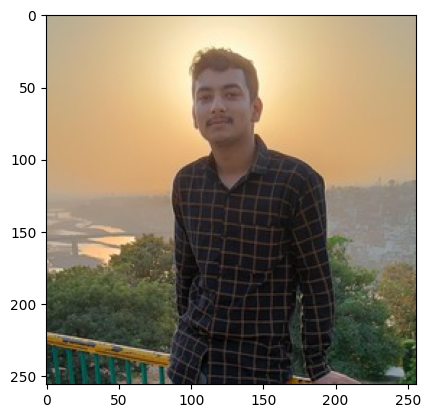

In [28]:
plt.imshow(img.permute(1, 2, 0))

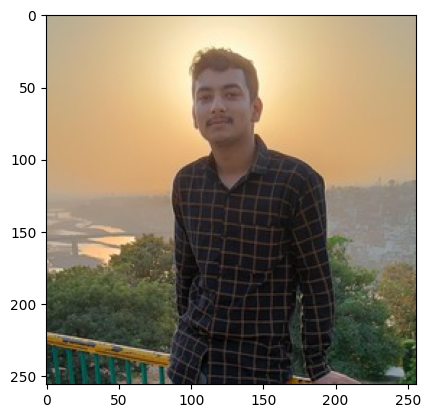

In [29]:
window_size = 16
scale = 1
mod_pad_h, mod_pad_w = 0, 0
_, h, w = img.size()
if h % window_size != 0:
    mod_pad_h = window_size - h % window_size
if w % window_size != 0:
    mod_pad_w = window_size - w % window_size
in_img = F.pad(img, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
plt.imshow(in_img.permute(1, 2, 0))

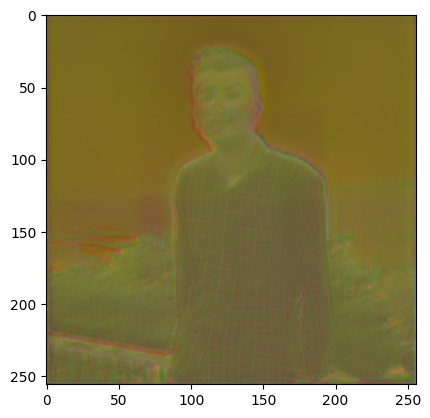

In [30]:
in_img = in_img.to(device)
out = model(in_img)
plt.imshow(out[0].detach().cpu().permute(1, 2, 0))

In [31]:
class uieb_data_loader(data.Dataset):

  def __init__(
    self,
    train_dataset,
    crop_size,
    test_dataset,
    mode = 'train'
  ):
    self.raw_path = train_dataset + 'raw/'
    self.gt_path = train_dataset + 'reference/'
    # self.illumination_path = train_dataset + 'illumination_prior/'
    # self.illumination_path = args.TRAIN_DATASET + 'depth_maps/'

    self.crop_size = crop_size
    train_list_path = train_dataset + 'train_list.txt'
    test_list_path = test_dataset + 'test_list.txt'

    self.mode = mode

    if self.mode == 'train':
      f = open(train_list_path)
    elif self.mode == 'test' or self.mode == 'valid':
      f = open(test_list_path)

    self.filenames = f.readlines()


  def __getitem__(self, item):

    raw_item_path = os.path.join(
      self.raw_path, self.filenames[item].rstrip())
    gt_item_path = os.path.join(
      self.gt_path, self.filenames[item].rstrip())
    # illumination_prior_path = os.path.join(
    #     self.illumination_path, self.filenames[item].rstrip())

    raw_img = Image.open(raw_item_path)
    gt_img = Image.open(gt_item_path)
    # illumination_img = Image.open(illumination_prior_path)
# sv
    transform = transforms.Compose([
      transforms.Resize((self.crop_size, self.crop_size)),
      transforms.ToTensor()
    ])

    return {
      'in_img': transform(raw_img),
      'label': transform(gt_img),
      # 'illumination': transform(illumination_img),
      'filename': self.filenames[item].rstrip()
    }

  def __len__(self):
    return len(self.filenames)


In [32]:
class uieb_unpaired_data_loader(data.Dataset):

  def __init__(
    self,
    train_dataset,
    crop_size
  ):
    self.raw_path = train_dataset + 'challenging-60/'
    # self.illumination_path = args.TRAIN_DATASET + 'challenging-60-illumination/'

    self.crop_size = crop_size
    non_reference_list_path = train_dataset + 'uie_non_reference.txt'

    f = open(non_reference_list_path)
    self.filenames = f.readlines()


  def __getitem__(self, item):

    raw_item_path = os.path.join(
      self.raw_path, self.filenames[item].rstrip())
    # illumination_prior_path = os.path.join(
    #     self.illumination_path, self.filenames[item].rstrip())

    raw_img = Image.open(raw_item_path)
    # illumination_img = Image.open(illumination_prior_path)

    transform = transforms.Compose([
      transforms.Resize((self.crop_size, self.crop_size)),
      transforms.ToTensor()
    ])

    transformed_img = transform(raw_img)

    return {
      'in_img': transformed_img,
      # 'label': transformed_img,
      # 'illumination': transform(illumination_img),
      'filename': self.filenames[item].rstrip()
    }

  def __len__(self):
    return len(self.filenames)


Total training image pairs: 16514
Total validation image pairs: 90
Total test unpaired images: 60


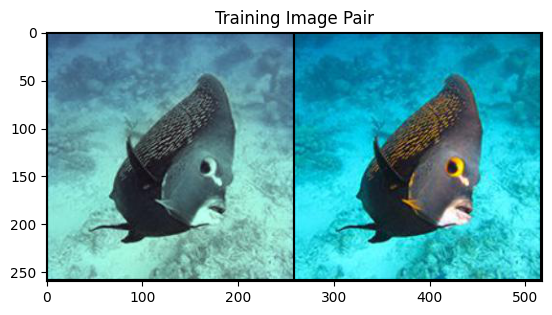

In [33]:
train_dataset = uieb_data_loader(train_dataset = './data/',
    crop_size = 256,
    test_dataset = './data/')

val_dataset = uieb_data_loader(train_dataset = './data/',
                               crop_size = 256,
                               test_dataset = './data/',
                               mode = 'valid')

test_dataset = uieb_unpaired_data_loader(train_dataset = './uieb_data/',
                                        crop_size = 256)

print("Total training image pairs:", len(train_dataset))
print("Total validation image pairs:", len(val_dataset))
print("Total test unpaired images:", len(test_dataset))

sample_train_image = next(iter(train_dataset))

grid = torch.vstack((sample_train_image['in_img'].unsqueeze(0), sample_train_image['label'].unsqueeze(0)))

plt.title("Training Image Pair")
plt.imshow(make_grid(grid).permute(1, 2, 0))

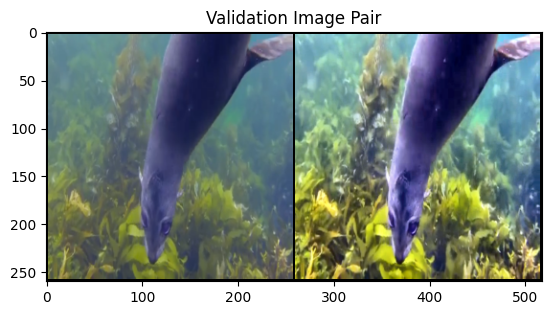

In [34]:
sample_val_image = next(iter(val_dataset))

grid = torch.vstack((sample_val_image['in_img'].unsqueeze(0), sample_val_image['label'].unsqueeze(0)))

plt.title("Validation Image Pair")
plt.imshow(make_grid(grid).permute(1, 2, 0))

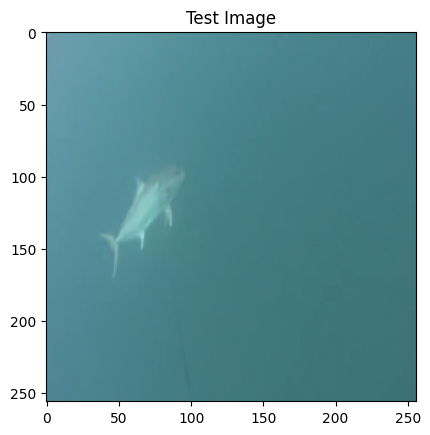

In [35]:
sample_test_image = next(iter(test_dataset))

plt.title("Test Image")
plt.imshow(sample_test_image['in_img'].permute(1, 2, 0))

In [36]:
train_dataloader = data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8, drop_last=True)
val_dataloader = data.DataLoader(val_dataset, batch_size = 2, shuffle = True, num_workers = 8, drop_last = True)
test_dataloader = data.DataLoader(test_dataset, batch_size = 2, shuffle = True, num_workers = 8, drop_last = True)

In [37]:
EXP_NAME = "multi_scale_hat_small_channel_fusion_AFF_added_large_dataset"

# Create the folder where the model weights are saved
samples_dir = os.path.join("samples", EXP_NAME)
results_dir = os.path.join("results", EXP_NAME)
make_directory(samples_dir)
make_directory(results_dir)

# create model training log
writer = SummaryWriter(os.path.join("samples", "logs", EXP_NAME))

In [38]:
# /home/ashutosh/anaconda3/envs/swinUIR/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
#   warnings.warn(msg)

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(weights = "DEFAULT").features[:4].eval())
        blocks.append(torchvision.models.vgg16(weights = "DEFAULT").features[4:9].eval())
        blocks.append(torchvision.models.vgg16(weights = "DEFAULT").features[9:16].eval())
        blocks.append(torchvision.models.vgg16(weights = "DEFAULT").features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input - self.mean) / self.std
        target = (target - self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners = False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners = False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss


In [39]:
class MyLoss(nn.Module):

    def __init__(self, lam_p = 1, lam_perceptual = 1):
        super(MyLoss, self).__init__()
        
        self.pixelwise_loss = nn.L1Loss()
        self.perceptual_loss = VGGPerceptualLoss()
        
        self.lam_p = 1
        self.lam_perceptual = 1

    def forward(self, recon, gt):
        return self.lam_p * self.pixelwise_loss(recon, gt) + self.lam_perceptual * self.perceptual_loss(recon, gt)

In [40]:
def train(epoch, train_dataloader, optimizer, netG, loss_fn, writer, num_batches):
    tbar = tqdm(train_dataloader)
    total_loss = 0.
    total = 0
    netG.train()
    
    for batch_index, batch in enumerate(tbar):
        # print(batch)
        gt = batch['label'].to(device)
        in_img = batch['in_img'].to(device)

        optimizer.zero_grad()

        reconstruction = netG(in_img)
        
        loss = loss_fn(reconstruction, gt)

        loss.backward()
        optimizer.step()

        total += 1
        total_loss += loss.item()
        avg_loss = total_loss / total

        # Output training log information once
        if batch_index % 10 == 0:
            # write training log
            iters = batch_index + epoch * num_batches
            writer.add_scalar("Train/Loss", avg_loss, iters)

        tbar.set_description("[Epoch {}] [Avg loss : {:.4f}]".format(epoch + 1, avg_loss))
        tbar.update()

In [41]:
def build_iqa_model(
        crop_border,
        only_test_y_channel,
        device
):
    psnr_model = PSNR(crop_border=crop_border, only_test_y_channel=only_test_y_channel, data_range=1.0)
    ssim_model = SSIM(crop_border=crop_border, only_test_y_channel=only_test_y_channel, data_range=255.0)

    psnr_model = psnr_model.to(device)
    ssim_model = ssim_model.to(device)

    return psnr_model, ssim_model


psnr_model, ssim_model = build_iqa_model(
    4,
    True,
    device,
)

In [42]:
def validate(epoch, netG, val_dataloader, psnr_model, ssim_model):
    netG.eval()

    with torch.no_grad():
        total_psnr = 0.
        total_ssim = 0.
        count = 0.
        epoch_result_dir = os.path.join(results_dir, "epoch_" + str(epoch + 1))

        make_directory(epoch_result_dir)

        for batch_index, batch in enumerate(val_dataloader):
            gt = batch['label'].to(device)
            lr = batch['in_img'].to(device)

            sr = netG(lr)

            psnr = psnr_model(sr, gt)
            ssim = ssim_model(sr, gt)

            total_psnr += psnr.mean().item()
            total_ssim += ssim.mean().item()

            count += 1

            lr_img = lr.detach().cpu()
            sr_img = sr.detach().cpu()
            gt_img = gt.detach().cpu()
            for i in range(len(batch['filename'])):
                grid = torch.vstack((lr_img[i].unsqueeze(0), sr_img[i].unsqueeze(0), gt_img[i].unsqueeze(0)))
                save_image(grid, os.path.join(epoch_result_dir, batch['filename'][i]))

        avg_psnr = total_psnr / count
        avg_ssim = total_ssim / count

        return avg_psnr, avg_ssim


In [ ]:
num_batches = len(train_dataloader)
start_epoch = 0
total_epochs = 100

best_psnr = 0.
best_ssim = 0.

load_epoch = None
optimizer = optim.Adam([{'params': model.parameters(), 'initial_lr': 0.0002}], betas=(0.9, 0.999))

loss_fn = MyLoss().to(device)

if load_epoch:
    start_epoch = load_epoch
    load_path = os.path.join(samples_dir, "epoch_{}.pth".format(load_epoch))
    checkpoint = torch.load(load_path)

    start_epoch = checkpoint["epoch"]
    best_psnr = max(best_psnr, checkpoint["psnr"])
    best_ssim = max(best_ssim, checkpoint["ssim"])
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    print("Loaded checkpoint with epoch {}, PSNR {:.4f} and SSIM {:.4f}".format(
        start_epoch, checkpoint["psnr"], checkpoint["ssim"]))


for epoch in range(start_epoch, total_epochs):
    # Train epoch
    train(epoch, train_dataloader, optimizer, model, loss_fn, writer, num_batches)
    
    # Validate epoch
    psnr, ssim = validate(epoch, model, val_dataloader, psnr_model, ssim_model)
    
    # Write the evaluation indicators of each round of Epoch to the log
    writer.add_scalar(f"Validation/PSNR", psnr, epoch + 1)
    writer.add_scalar(f"Validation/SSIM", ssim, epoch + 1)
    
    best_psnr = max(psnr, best_psnr)
    best_ssim = max(ssim, best_ssim)
    
    print("[Epoch {}] [Avg PSNR: {:.4f}] [Avg SSIM: {:.4f}]".format(epoch + 1, psnr, ssim))
    
    save_path = os.path.join(samples_dir, "epoch_{}.pth".format(epoch  + 1))
    
    torch.save({
        "epoch": epoch + 1,
        "psnr": psnr,
        "ssim": ssim,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }, save_path)

print("Best PSNR: {} and SSIM : {}".format(best_psnr, best_ssim))

# Finetune on underwater in the morning.

[Epoch 1] [Avg loss : 2.1035]:  19%|███████▏                             | 1600/8257 [30:12<1:53:22,  1.02s/it]

In [ ]:
matlab_lr = transforms.ToTensor()(Image.open("./uieb_data/raw-890/1225.png"))

plt.imshow(matlab_lr.permute(1, 2, 0))

In [ ]:
window_size = 16
scale = 1
mod_pad_h, mod_pad_w = 0, 0
_, h, w = matlab_lr.size()
if h % window_size != 0:
    mod_pad_h = window_size - h % window_size
if w % window_size != 0:
    mod_pad_w = window_size - w % window_size
in_img = F.pad(matlab_lr, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
in_img = transforms.Resize((256, 256))(in_img)
plt.imshow(in_img.permute(1, 2, 0))

# matlab_lr.unsqueeze(0)
in_img = in_img.to(device)


sr_img = model(in_img)

In [ ]:
sr_img = sr_img.squeeze(0).detach().cpu()
save_image(sr_img, "./output.png")

plt.imshow(sr_img.permute(1, 2, 0))

In [ ]:
gt = transforms.ToTensor()(Image.open("./uieb_data/reference-890/1225.png"))

window_size = 16
scale = 1
mod_pad_h, mod_pad_w = 0, 0
_, h, w = gt.size()
if h % window_size != 0:
    mod_pad_h = window_size - h % window_size
if w % window_size != 0:
    mod_pad_w = window_size - w % window_size
gt = F.pad(gt, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
gt_img = transforms.Resize((256, 256))(gt)

grid = torch.vstack((in_img.cpu().unsqueeze(0), sr_img.cpu().unsqueeze(0), gt_img.cpu().unsqueeze(0)))

result = make_grid(grid).permute(1, 2, 0)

result = Image.fromarray((result.numpy() * 255).astype(np.uint8))
print(result)
plt.imshow(result)

result.save("./result.png")